In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re,html,json

In [5]:
df = pd.read_excel('Canada_Election_2022_TestData.xlsx')

In [6]:
df.shape

(5000, 3)

In [7]:
df_main = df[['created_at','full_text','user.location']].head(5000)

In [8]:
df_main.describe()

,created_at,full_text,user.location
count,5000,5000,3389
unique,3876,3921,1121
top,Wed Jun 01 14:06:52 +0000 2022,@liberal_party @liberal_party &amp; @JustinTru...,Canada
freq,4,5,291


In [9]:
expression = re.compile(r'[&#;?:^${}\[\]\\]')
def impurity(text,min_len=10):
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(expression.findall(text))/len(text)

In [10]:
df_main['impurity_score'] = df_main['full_text'].apply(impurity, min_len=10)

In [11]:
df_main['impurity_score'].describe()  

count    5000.000000
mean        0.006726
std         0.009634
min         0.000000
25%         0.000000
50%         0.003636
75%         0.010000
max         0.075163
Name: impurity_score, dtype: float64

In [12]:
# Function to clean the text.

import re,html
def clean(text):
    #lower
    text = text.lower()
    #tags like <tag>
    text = re.sub(r'<[^<>]*>', ' ',text)
    #Markdown Urls
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)',r'\1',text)
    #Remove Punctuation
    text = re.sub(r'([!?,])\1+', r'\1', text)
    #Remove all URL's
    text = re.sub(r'http.*', ' ', text)
    #Remove @
    text = re.sub(r'@\w*', ' ', text)
    #text or code in brackets
    text = re.sub(r'\[[^\[\]]*\]',' ',text)
    # remove b"
    text = text.replace('b\"',' ') 
    # remove b'
    text = text.replace("b\'",' ') 
    # remove \\n
    text = text.replace('\\n',' ')
    #Remove &amp
    text = text.replace('&amp',' ') 
    # remove UTF-8 code like \\xe2
    text = re.sub(r'(\\x(.){2})', ' ',text) 
    #Standalone sequences for specials
    text = re.sub(r'(?:^|\s)[;.\'\"&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ',text)
    #stand alone sequence of hyphens 
    text= re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ',text)
    # Sequence of white spaces
    text = re.sub(r'\s+',' ',text)
    return text.strip()

In [13]:
def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

In [14]:
def normalize_contractions(sentence_list):
    contraction_list = json.loads(open('english_contractions.json', 'r').read())
    norm_sents = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_normalize_contractions_text(sentence, contraction_list))
    return norm_sents

contraction_list = json.loads(open('english_contractions.json', 'r').read())

In [15]:
df_main['clean_text'] = df_main['full_text'].map(clean)

In [16]:
df_main['clean_text'] = normalize_contractions(df_main['clean_text'])

Normalizing contractions


100%|██████████| 5000/5000 [00:00<00:00, 106383.13it/s]


In [17]:
import nltk as nt
from nltk.corpus import stopwords
nt.download('stopwords')
sw = stopwords.words( 'english' )
my_list = ['I','The',"b'It",'On']
sw = sw + my_list
def remove_stopwords(text):
    l = []
    for i in text.split():
        if i not in sw:
            l.append(i.strip('\'\"'))
    return l

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\noahr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df_main['tokens'] = df_main['clean_text'].apply(remove_stopwords)

In [19]:
df_main.sample(5)

,created_at,full_text,user.location,impurity_score,clean_text,tokens
3531,Mon May 30 19:33:35 +0000 2022,Every single member of @liberal_party and @NDP...,NaN,0.025974,every single member of and are enemies of the ...,"[every, single, member, enemies, people, treat..."
2164,Thu Jun 02 19:26:02 +0000 2022,"Elections Ontario confirms technical issues, s...",NaN,0.007634,"elections ontario confirms technical issues, s...","[elections, ontario, confirms, technical, issu..."
1917,Fri May 27 01:21:58 +0000 2022,@NanananaBrown Elections have changed in Canad...,"Nonhuman,NoRights, Canada 🇨🇦",0.000000,"elections have changed in canada, these electi...","[elections, changed, canada,, elections, becom..."
344,Fri Jun 03 01:59:31 +0000 2022,@AnneofKingston NDP lost because of liberals p...,NaN,0.000000,ndp lost because of liberals participation in ...,"[ndp, lost, liberals, participation, election...."
2796,Sun May 29 00:53:52 +0000 2022,@RonFilipkowski Hey Charlie. Travel just north...,NaN,0.000000,hey charlie. travel just north into canada tha...,"[hey, charlie., travel, north, canada, free, s..."


In [20]:
from collections import Counter

counter = Counter()

df_main['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
4995    None
4996    None
4997    None
4998    None
4999    None
Name: tokens, Length: 5000, dtype: object

# MostCommon Words in the 2022 Election data

<AxesSubplot:xlabel='Word'>

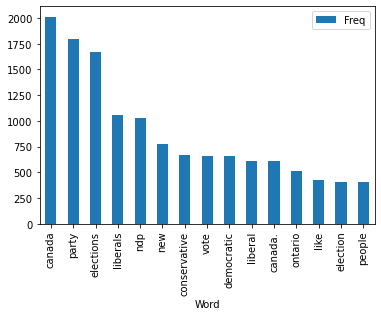

In [21]:
most_common = pd.DataFrame(counter.most_common(15),columns=['Word','Freq'])
most_common.plot(kind='bar',x='Word',y='Freq')

Text(0.5, 1.0, 'Word Cloud on Total Clean_text')

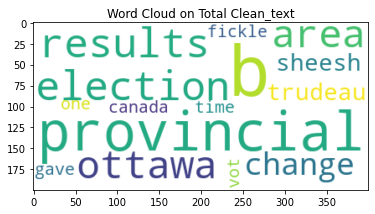

In [22]:
from wordcloud import WordCloud

text = str(df_main['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Total Clean_text')

Text(0.5, 1.0, 'Word Cloud on Total Counter Values')

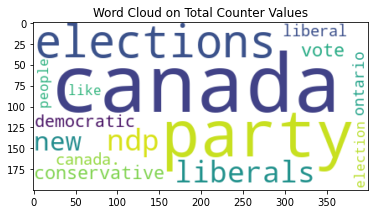

In [23]:
from wordcloud import WordCloud

wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate_from_frequencies(counter)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Total Counter Values')

# DATA MINING

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

In [25]:
#BOW

def bag_of_words(tweets):
    tokenized = tokenizer(preprocessor(tweets))
    
    words = {}
    
    for i in tokenized:
        if i in words.keys():
            words[i]+=1
        else:
            words[i] = 1
    return words

In [26]:
def party(tweets):
    
    bow = bag_of_words(tweets)
    
    liberals = ["justin","justintrudeau","lpc","liberalparty","Forward","justin4pm","teamtrudeau","liberal","liberals",'timeforchange','#ChooseForward','voteliberals','justnotready','liberal_party','trudeau','trudeaumania']
    conservatives = ['conservativeparty','Doug','#DougFord','#Ford','cpc','conservative','conservatives']
    ndp = ['#JagmeetSingh','JagmeetSingh','#ndp','@theJagmeetSingh','ndp','npd','NDP','#UpRiSingh','votendp','ndpleader','ndpcanada']
    other_parties = [ 'green','greenparty', 'gpc','canadiangreens','greenpartyofcanada','@peoplespca','elizabethmay','votegreen','polqc','paysqc','jevotebloc','ppc','bloc','blocqc','greenpeace']
    other_election_topics = ["cdnpoli","#cdnpoli","elxn","#elxn","vote","#EtobicokeNorth",'#Alberta','#Ontario','QC']
    party = {"liberals":0,"conservatives":0,"ndp":0,"other_parties":0,"other_election_topics":0,"unrelated tweets":0}
    
    for i in bow:
        if i in liberals:
            party["liberals"]+=bow[i]
            
        if i in conservatives:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['conservatives'] += bow[i]
        
        if i in ndp:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['ndp'] += bow[i]
        
        if i in other_parties:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['other_parties'] += bow[i]
            
        if i in other_election_topics:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['other_election_topics'] += bow[i]
            
    party_name = 'unrelated tweets'
    for key in party:
        if party[key] > party[party_name]:
            #update party name value
            party_name = key
    
    
    return party_name

In [27]:
df_main['Party'] = df_main['clean_text'].apply(party)
df_main.sample(10)

,created_at,full_text,user.location,impurity_score,clean_text,tokens,Party
4876,Mon May 30 13:20:13 +0000 2022,What we’re doing is 💯 not new or a secret - bu...,"Texas, USA",0.003584,what we’re doing is 💯 not new or a secret but ...,"[we’re, 💯, new, secret, truth, it’s, hard, wor...",unrelated tweets
1608,Tue May 31 00:06:41 +0000 2022,@SkykingMilk @AlanCane604 Bombard elections ca...,NaN,0.000000,bombard elections canada to demand why the 205...,"[bombard, elections, canada, demand, 205,000, ...",unrelated tweets
4676,Wed Jun 01 01:15:11 +0000 2022,NEW F497\nLos Angeles County Democratic Party ...,"The Cloud, CA",0.030303,new f497 los angeles county democratic party i...,"[new, f497, los, angeles, county, democratic, ...",unrelated tweets
570,Fri Jun 03 01:31:20 +0000 2022,"@ColeDahmer agree, but I think the Liberals an...","Kailua, HI",0.000000,"agree, but i think the liberals and ndp should...","[agree,, think, liberals, ndp, examine, exactl...",liberals
3378,Tue May 31 13:05:07 +0000 2022,For those clapping at Justin Trudeau's announc...,NaN,0.000000,for those clapping at justin trudeau's announc...,"[clapping, justin, trudeau's, announcement, gu...",liberals
2953,Thu May 26 17:03:39 +0000 2022,The Wexit movement organized provincial partie...,Earth,0.000000,the wexit movement organized provincial partie...,"[wexit, movement, organized, provincial, parti...",liberals
3753,Fri May 27 10:06:00 +0000 2022,@EffieGib No he didn't. Ppl like you are destr...,"Toronto, Ontario",0.000000,no he didn't. ppl like you are destroying cana...,"[didn't., ppl, like, destroying, canada, racis...",liberals
1995,Thu May 26 04:13:57 +0000 2022,@JiminySpeaks @StevenDelDuca @OntLiberal Nobod...,"Ajax, Ontario",0.000000,"nobody ""wins"" elections in canada, just like h...","[nobody, wins, elections, canada,, like, nobod...",unrelated tweets
1598,Tue May 31 00:51:35 +0000 2022,@thegregoryyoung @Sani91510702 @CandiceBergenM...,"Victoria, BC",0.012048,winning elections power is one thing about dem...,"[winning, elections, power, one, thing, democr...",conservatives
2090,Fri Jun 03 00:33:44 +0000 2022,"According to Wikipedia, Turmel has run in 102 ...",Ottawa/Unceded Algonquin Land,0.004367,"according to wikipedia, turmel has run in 102 ...","[according, wikipedia,, turmel, run, 102, prev...",unrelated tweets


In [28]:
df_main['full_text'].iloc[1096]

'Girlfriend’s aunt was interviewed by a tv network in canada and she said she lived in Ilocos at the time of FEM and she’s happy that the spawn won the presidential elections because when she was still in Ilocos, she had a fun life, under FEM’s dictatorship. Ruined my morning.'

In [29]:
df_main.Party.value_counts() 

unrelated tweets         2154
liberals                 1714
conservatives             570
other_election_topics     439
ndp                        93
other_parties              30
Name: Party, dtype: int64

C:\Users\noahr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Party', ylabel='count'>

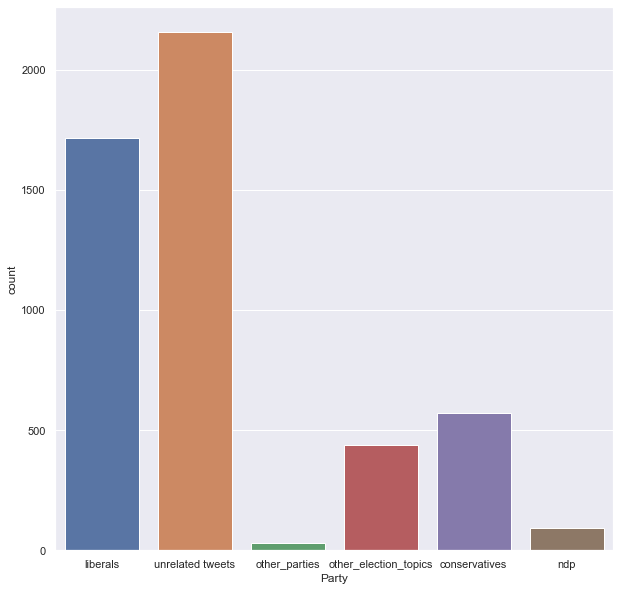

In [30]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(10,10)})
sns.countplot(df_main["Party"])

In [31]:
#Calculating sentiment through Text Blob
from textblob import TextBlob
sentiment = []
emotions = []

for i in df_main.clean_text:
    s = TextBlob(i)
    sentiment.append(s.sentiment.polarity)
    if s.sentiment.polarity > 0:
        emotions.append("Positive")
    elif s.sentiment.polarity < 0:
        emotions.append("Negative")
    else:
        emotions.append("Neutral")

In [32]:
df_main["Textblob_Sentiments"] = sentiment
df_main["Emotions"] = emotions

In [33]:
df_main[['clean_text','Textblob_Sentiments','Emotions']].head()

,clean_text,Textblob_Sentiments,Emotions
0,"b sheesh, trudeau gave you a one time $500 vot...",0.00,Neutral
1,provincial election results in the ottawa area...,0.00,Neutral
2,provincial election results in the ottawa area,0.00,Neutral
3,canada is a very fickle nation: in the 2021 el...,0.32,Positive
4,why don’t you also tell canadians that monkeyp...,0.00,Neutral


In [34]:
df_main.Emotions.value_counts() 

Positive    2522
Negative    1340
Neutral     1138
Name: Emotions, dtype: int64

Text(0.5, 1.0, 'Sentiments in 2021 election sentiments')

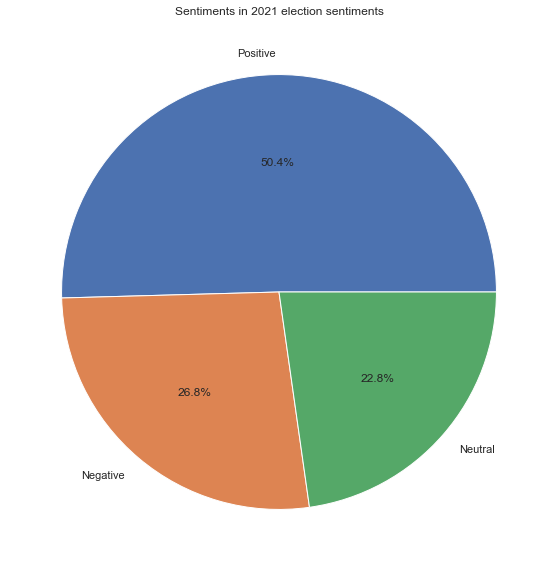

In [35]:
df1 = pd.DataFrame(df_main['Emotions'].value_counts().reset_index())
plt.pie(data=df1,x="Emotions",labels="index",autopct='%.1f%%')
plt.title("Sentiments in 2021 election sentiments")

Text(0.5, 1.0, 'Word Cloud on Positive Tweets')

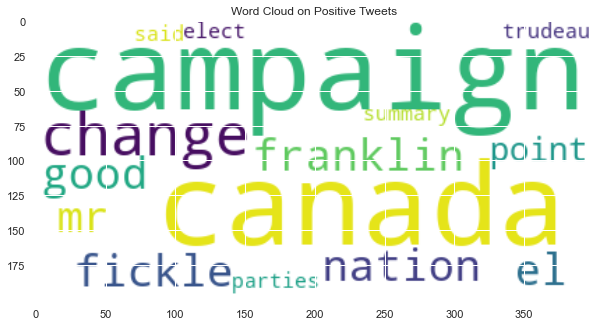

In [36]:
text = str(df_main.query("Emotions == 'Positive'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Positive Tweets')

Text(0.5, 1.0, 'Word Cloud on negative Tweets')

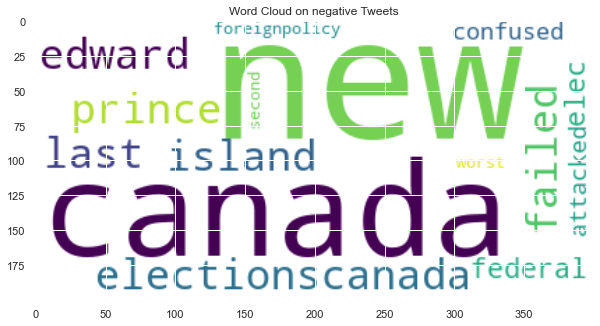

In [37]:
text = str(df_main.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on negative Tweets')

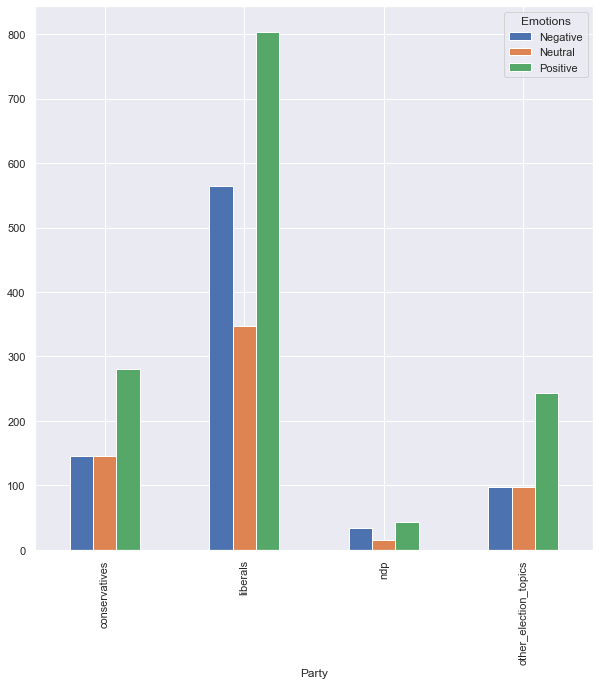

In [38]:
df2= df_main.groupby(['Party'])['Emotions'].value_counts()[:12].unstack().plot(kind='bar',stacked = False)
sns.set(rc = {'figure.figsize':(20,20)})

In [39]:
LPC_tweets = df_main[df_main["Party"]=="liberals"]
ndp_tweets = df_main[df_main["Party"]=="ndp"]
conservatives_tweets = df_main[df_main["Party"]=="conservatives"]
Percentage_pos_lpc = LPC_tweets.Emotions.value_counts()[1]/len(LPC_tweets)*100
Percentage_neg_lpc = LPC_tweets.Emotions.value_counts()[2]/len(LPC_tweets)*100
Percentage_pos_ndp = ndp_tweets.Emotions.value_counts()[1]/len(ndp_tweets)*100
Percentage_neg_ndp = ndp_tweets.Emotions.value_counts()[2]/len(ndp_tweets)*100
Percentage_pos_conservatives = conservatives_tweets.Emotions.value_counts()[1]/len(conservatives_tweets)*100
Percentage_neg_conservatives = conservatives_tweets.Emotions.value_counts()[2]/len(conservatives_tweets)*100

In [40]:
print(f"Percentage of tweets positive on LPC is : {Percentage_pos_lpc} %")
print(f"Percentage of tweets negative on LPC is : {Percentage_neg_lpc} %")
print(f"Percentage of tweets positive on NDP is : {Percentage_pos_ndp} %")
print(f"Percentage of tweets negative on NDP is : {Percentage_neg_ndp} %")
print(f"Percentage of tweets positive on conservatives is : {Percentage_pos_conservatives} %")
print(f"Percentage of tweets negative on conservatives is : {Percentage_neg_conservatives} %")

Percentage of tweets positive on LPC is : 32.90548424737456 %
Percentage of tweets negative on LPC is : 20.245040840140025 %
Percentage of tweets positive on NDP is : 36.55913978494624 %
Percentage of tweets negative on NDP is : 17.20430107526882 %
Percentage of tweets positive on conservatives is : 25.438596491228072 %
Percentage of tweets negative on conservatives is : 25.438596491228072 %


In [41]:
LPC_tweets

,created_at,full_text,user.location,impurity_score,clean_text,tokens,Party,Textblob_Sentiments,Emotions
0,Fri Jun 03 02:10:09 +0000 2022,"b@northstaray @SGirardau Sheesh, Trudeau gave ...",NaN,0.014286,"b sheesh, trudeau gave you a one time $500 vot...","[b, sheesh,, trudeau, gave, one, time, $500, v...",liberals,0.000000,Neutral
12,Wed Jun 01 03:59:31 +0000 2022,"I was confused why [Singh, OToole, Blanchet] a...","Tkaronto / Toronto, Canada",0.055276,"i was confused why attacked re #foreignpolicy,...","[confused, attacked, #foreignpolicy,, name-dro...",liberals,-0.400000,Negative
14,Tue May 31 18:47:44 +0000 2022,Here's what Trudeau said during the 2021 elect...,Canada,0.013201,here's what trudeau said during the 2021 elect...,"[here's, trudeau, said, 2021, election, campai...",liberals,0.108333,Positive
15,Tue May 31 17:59:37 +0000 2022,@InOkanagan @Frankiecheese2 @10hody @spacetime...,NaN,0.010000,it was over in canada when trudeau held an imp...,"[canada, trudeau, held, impromptu, unneeded, e...",liberals,0.000000,Neutral
16,Tue May 31 17:43:54 +0000 2022,You are the second worst thing to happen to Ca...,Canadian,0.007042,you are the second worst thing to happen to ca...,"[second, worst, thing, happen, canada, last, d...",liberals,-0.333333,Negative
...,...,...,...,...,...,...,...,...,...
4924,Mon May 30 01:22:14 +0000 2022,@jasrajshallan The New Liberal Democratic Part...,"Calgary, Alberta",0.000000,the new liberal democratic party will not let ...,"[new, liberal, democratic, party, let, happen.]",liberals,0.136364,Positive
4967,Sun May 29 15:28:02 +0000 2022,@ZachH1988 @davidshor @JohnnyFrontier @dareade...,Houston & Dallas,0.008772,it’s a tribalism that’s far different than mos...,"[it’s, tribalism, that’s, far, different, peop...",liberals,0.138528,Positive
4973,Sun May 29 14:48:11 +0000 2022,@ohgrapes1 @brithume He was liberal and his “N...,"Malden, MA",0.000000,he was liberal and his “new frontier” was a mo...,"[liberal, “new, frontier”, movement, toward, y...",liberals,-0.087879,Negative
4984,Sun May 29 13:15:29 +0000 2022,@Consume81958121 @JimMurp77852985 @SDC23997103...,"Kingston, Ontario",0.000000,hard to imagine anyone in the country more ang...,"[hard, imagine, anyone, country, angry, unvacc...",liberals,-0.009217,Negative


Text(0.5, 1.0, 'Word Cloud on LPC Negative Tweets')

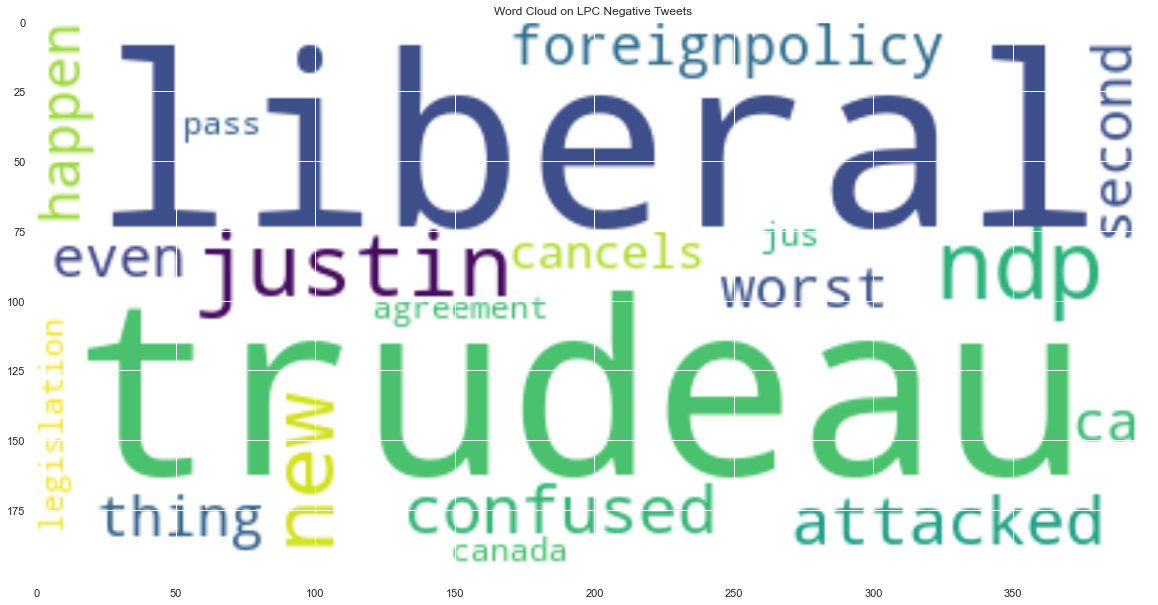

In [42]:
from wordcloud import WordCloud

text = str(LPC_tweets.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=20,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on LPC Negative Tweets')

Text(0.5, 1.0, 'Word Cloud on LPC Postive Tweets')

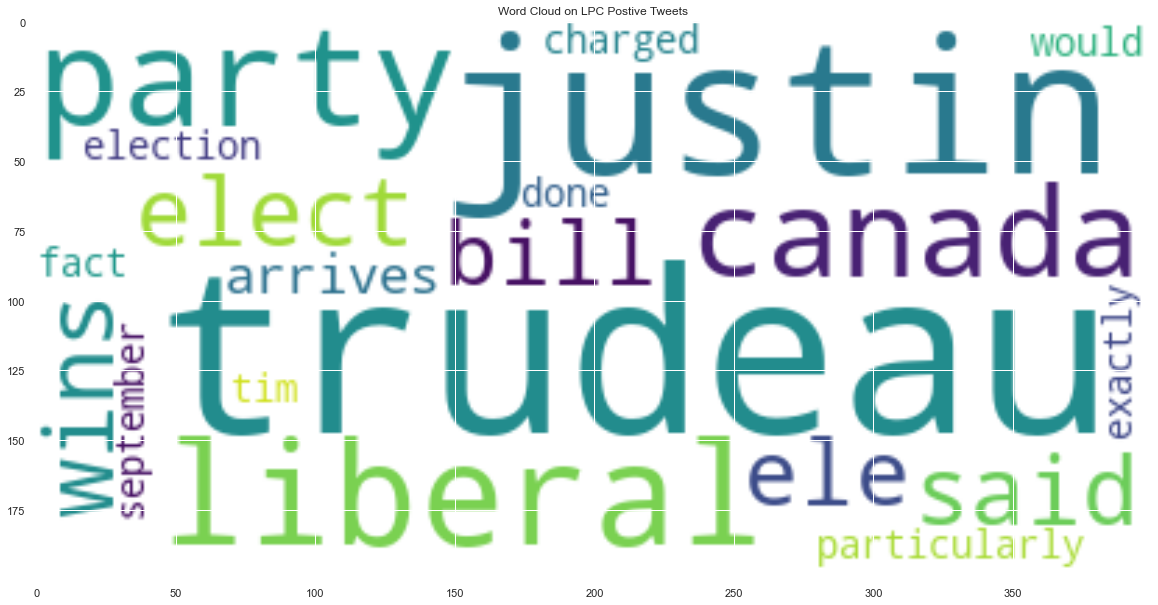

In [43]:
text = str(LPC_tweets.query("Emotions == 'Positive'")['clean_text'])
wc = WordCloud(max_words=20,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on LPC Postive Tweets')

Text(0.5, 1.0, 'Word Cloud on LPC Negative Tweets')

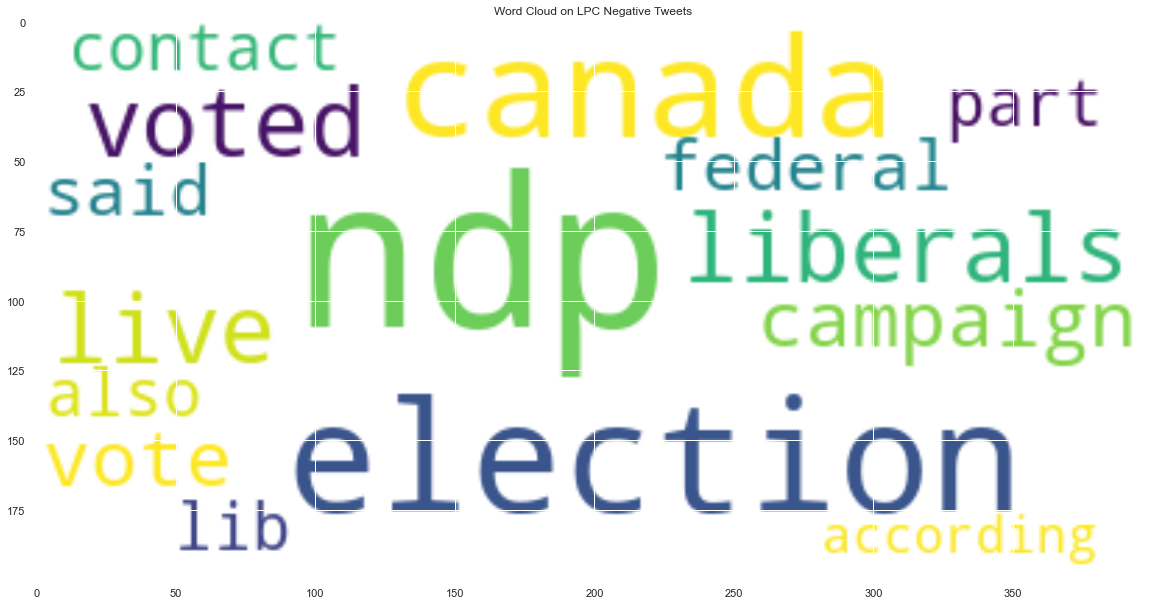

In [44]:
text = str(ndp_tweets.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on LPC Negative Tweets')

Text(0.5, 1.0, 'Word Cloud on NPC Tweets')

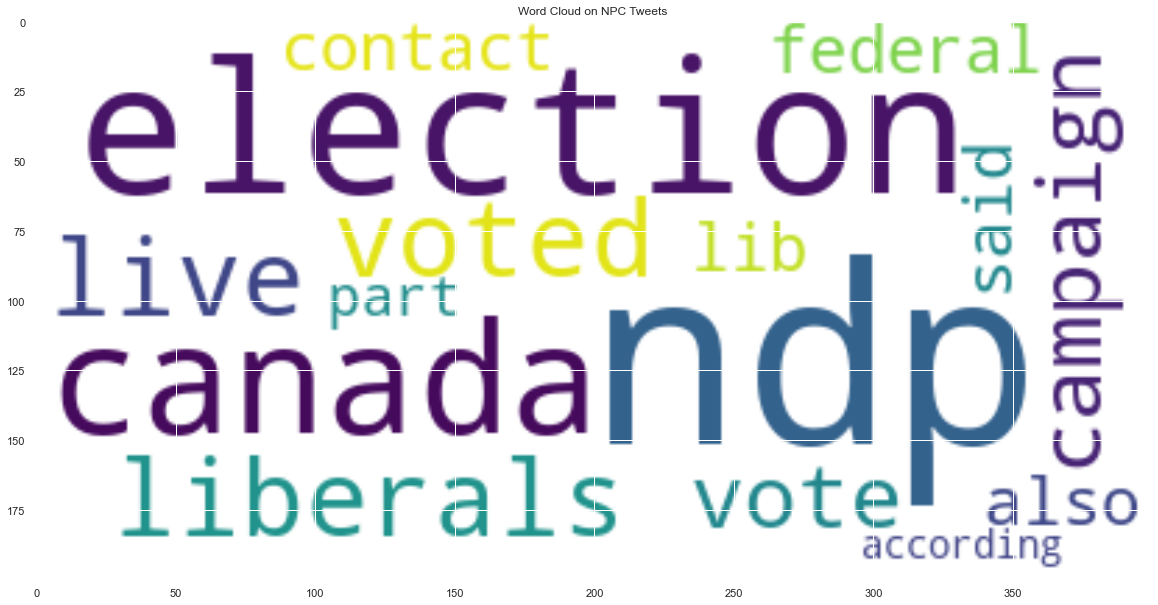

In [45]:
text = str(ndp_tweets.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on NPC Tweets')

Text(0.5, 1.0, 'Word Cloud on CON Tweets')

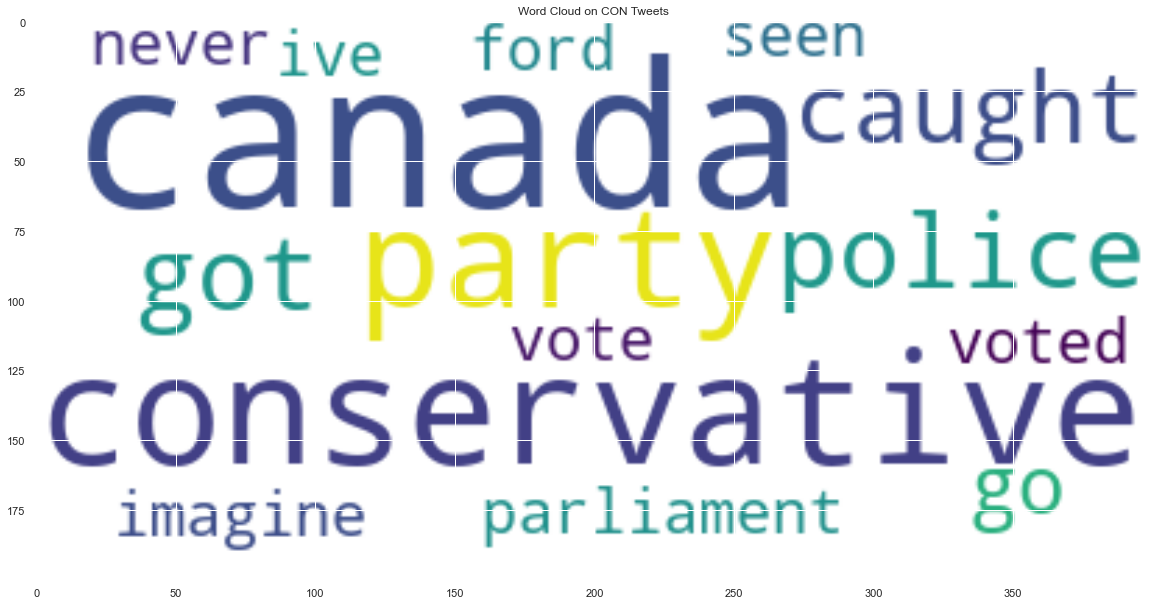

In [46]:
text = str(conservatives_tweets.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on CON Tweets')

In [47]:
text = str(conservatives_tweets.query("Emotions" == "Positive")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on CON Tweets')

ValueError: expr must be a string to be evaluated, <class 'bool'> given